In [1]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader


%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
## Device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'); DEVICE

device(type='cuda', index=0)

In [3]:
"""
Prepare Dataset using Dataloader
"""
class MNIST():

    def __init__(self, csv, img_file, transform=None):
        df = pd.read_csv(csv)
        self.img_file = img_file
        self.img_id = df['image']
        self.y = df['label']
        self.transform = transform

        
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_file,
                                      self.img_id[index]))
        
        label = self.y[index]
        if self.transform is not None:
            img = self.transform(img)
        
        return img, label

    
    def __len__(self):
        return self.y.shape[0]
    
    
# Hyperparameters 
BATCH_SIZE = 256
RANDOM_SEED = 123
LEARNING_RATE = 0.003
NUM_EPOCHS = 25
BATCH_SIZE = 128

# Architecture
num_features = 32*32
num_classes = 10

    
train_transform = transforms.Compose([transforms.Resize((32, 32)),
                                      transforms.ToTensor()])

val_transform = transforms.Compose([transforms.Resize((32, 32)),
                                    transforms.ToTensor()])

train_dataset = MNIST(csv='customed_train.csv',
                      img_file='mnist_train',
                      transform=train_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          num_workers=4)

valid_dataset = MNIST(csv='customed_valid.csv',
                      img_file='mnist_val',
                      transform=val_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

## Modified LeNet-5

In [4]:
class LeNet5(nn.Module):

    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        
        self.num_classes = num_classes

        #since an image is gray scale
        in_channels = 1


        self.features = nn.Sequential(
            # 32*32 input with 1 channel
            nn.Conv2d(in_channels, 6, kernel_size=5, stride=1, padding=0),
            # 28*28 output with 6 channels
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            # 14*14 output with 6 channels
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            # 10*10 output with 16 channels
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            # 5*5 output with 16 channels
        )

        self.classifier = nn.Sequential(
            # full connection 
            nn.Linear(16*5*5, 120),
            nn.Tanh(),
            # full connection
            nn.Linear(120, 84),
            nn.Tanh(),
            # full connection
            nn.Linear(84, num_classes),
        )


    def forward(self, x):
#         print("before features", x.size())
        x = self.features(x)
#         print("beofre flatten", x.size())
        x = torch.flatten(x, 1)
#         print("after flatten", x.size())
        z = self.classifier(x)
        probas = F.softmax(z, dim=1)
        return z, probas

In [5]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(num_classes)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 

In [6]:
def train_model(model, data_loader, ith_epoch, epochs):
    model.train()
    loss_per_epoch = 0 
    
    for batch_idx, (features, targets) in enumerate(data_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        
        z, probs = model(features)
        
        loss = F.cross_entropy(z, targets)
        loss_per_epoch += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
           
        
        if (batch_idx)% 50 == 0:
            print(f'Epoch: {ith_epoch+1:02d}/{epochs:02d} | '
                  f'Batch: {batch_idx:03d}/{len(data_loader):03d} | Loss: {loss:.3f}')

In [7]:
def compute_accuracy_and_loss(model, data_loader):
    correct_pred = 0
    num_examples = 0
    cross_entropy = 0.
    
    model.eval()
    for features, targets in data_loader:
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        z, probs = model(features)
        cross_entropy += F.cross_entropy(z, targets).item()
        _, predicted_labels = torch.max(probs, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples

In [8]:
train_acc_list, train_loss_list = [], []
valid_acc_list, valid_loss_list = [], []

for ith_epoch in range(NUM_EPOCHS):
    train_model(model, train_loader, ith_epoch, NUM_EPOCHS)
    train_acc, train_loss = compute_accuracy_and_loss(model, train_loader)
    valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    valid_acc_list.append(valid_acc)
    valid_loss_list.append(valid_loss)
    
    print(f'Epoch: {ith_epoch+1:02d}/{NUM_EPOCHS:02d} | Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')

Epoch: 01/25 | Batch: 000/263 | Loss: 2.299
Epoch: 01/25 | Batch: 050/263 | Loss: 0.325
Epoch: 01/25 | Batch: 100/263 | Loss: 0.129
Epoch: 01/25 | Batch: 150/263 | Loss: 0.105
Epoch: 01/25 | Batch: 200/263 | Loss: 0.150
Epoch: 01/25 | Batch: 250/263 | Loss: 0.038
Epoch: 01/25 | Train Acc.: 97.55% | Validation Acc.: 97.05%
Epoch: 02/25 | Batch: 000/263 | Loss: 0.066
Epoch: 02/25 | Batch: 050/263 | Loss: 0.106
Epoch: 02/25 | Batch: 100/263 | Loss: 0.043
Epoch: 02/25 | Batch: 150/263 | Loss: 0.045
Epoch: 02/25 | Batch: 200/263 | Loss: 0.068
Epoch: 02/25 | Batch: 250/263 | Loss: 0.040
Epoch: 02/25 | Train Acc.: 98.38% | Validation Acc.: 97.94%
Epoch: 03/25 | Batch: 000/263 | Loss: 0.105
Epoch: 03/25 | Batch: 050/263 | Loss: 0.057
Epoch: 03/25 | Batch: 100/263 | Loss: 0.023
Epoch: 03/25 | Batch: 150/263 | Loss: 0.044
Epoch: 03/25 | Batch: 200/263 | Loss: 0.042
Epoch: 03/25 | Batch: 250/263 | Loss: 0.084
Epoch: 03/25 | Train Acc.: 99.15% | Validation Acc.: 98.31%
Epoch: 04/25 | Batch: 000/26

## Evaluation

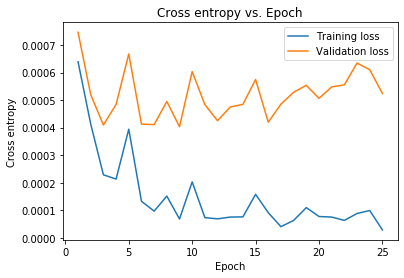

In [9]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_list, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_list, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Cross entropy vs. Epoch')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

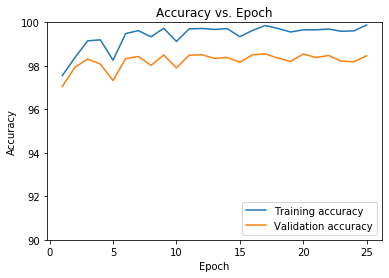

In [10]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_list, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_list, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy vs. Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([90, 100])
plt.show()

## Run on test data

In [11]:
# Make predictions on test set
test = pd.read_csv("digit-recognizer/test.csv").values
test = test.reshape(28000, 1, 28, 28)/255.
test = np.pad(test, ((0, 0), (0, 0), (2, 2), (2, 2)), 'constant')
test = torch.tensor(test, dtype=torch.float)
test = test.to(DEVICE)

model.eval()
z, probas = model(test)
_, predicted_labels = torch.max(probas, 1)

imageID = list(i for i in range(1, len(test)+1))
data = {'ImageId':imageID, 'Label':predicted_labels.cpu().data.numpy()} 
  
    
# Create DataFrame 
df = pd.DataFrame(data); df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [12]:
df.to_csv("test11.csv", index=False)

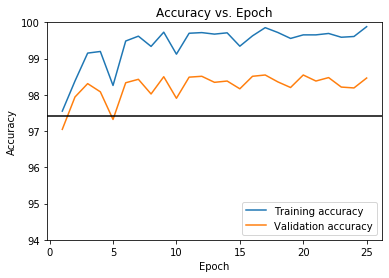

In [15]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_list, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_list, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy vs. Epoch')
plt.axhline(y=97.428, color='black')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([94, 100])
plt.show()